# Libraries:

In [130]:
# Basics:
import numpy as np
import pickle

# Importing, Engineering, and Transforming data:
import pandas as pd

# Plotting and transforming dates to int:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# SVM Model:
from sklearn.svm import SVR

# Model Evaluation:
from sklearn.metrics import mean_squared_error

# LSTM Model:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model

# import pandas_datareader.data as web
# import datetime

# from matplotlib import style

# ignore warnings 
# import warnings
# warnings.filterwarnings('ignore')

# Importing and Formating Data:

## Importing:
Lets import the whole dataframe first:

In [30]:
#Importing dataframe:
# df = pd.read_csv('data/btc_full.csv')
df = pd.read_excel('data/btc_partial_features.xls')
df

,Time,BTC / USD Denominated Closing Price,BTC / Free Float Market Cap (USD),BTC / Realized Market Cap (USD),BTC / Active Market Cap (1yr) (USD),BTC / 30 Day Volatility,BTC / 180 Day Volatility,"BTC / ROI, 1 Year","BTC / ROI, 30 Days",BTC / Annual Inflation Rate,...,BTC / Value in Top 10% of Addrs (native units),BTC / Value in Top 1% of Addrs (native units),BTC / Total Fees (native units),BTC / Miner Revenue (native units),BTC / NVT,BTC / Mean Hash Rate,BTC / Difficulty,BTC / Exchange Deposits (native units),BTC / Exchange Withdrawals (native units),BTC / Miner Supply (native units)
0,2009-01-03,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
1,2009-01-04,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
2,2009-01-05,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
3,2009-01-06,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
4,2009-01-07,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,2021-10-16,60932.063212,8.850671e+11,4.167951e+11,5.282887e+11,0.041404,0.042173,437.367776,27.480061,1.609965,...,1.866171e+07,1.725065e+07,15.434662,846.684662,84.956180,1.315222e+08,1.989305e+13,19749.903680,11579.048564,1.798318e+06
4670,2021-10-17,61462.222372,8.928154e+11,4.174171e+11,5.327219e+11,0.041225,0.042169,440.907262,30.178528,1.936697,...,1.866253e+07,1.725102e+07,11.310294,1011.310294,117.153052,1.582222e+08,1.989305e+13,9566.307540,11389.491044,1.798489e+06
4671,2021-10-18,61977.057551,9.003317e+11,4.204438e+11,5.393226e+11,0.041163,0.042039,439.417698,28.572401,1.791357,...,1.866385e+07,1.725614e+07,15.971247,940.971247,57.017267,1.465815e+08,2.008246e+13,23466.427777,26568.856321,1.798324e+06
4672,2021-10-19,64290.897757,9.340006e+11,4.224533e+11,5.598689e+11,0.041098,0.042009,447.351668,36.156238,1.875987,...,1.866471e+07,1.725672e+07,14.856384,983.606384,57.787489,1.547372e+08,2.008246e+13,33603.268908,39997.994668,1.798231e+06


## Exploring Nulls:
Now let's create a function to look for the row number when each feature starts having continuosly valid data. We will use it later to drop the early datapoints that contains null values: 

In [31]:
# Finding the oldest nulls in the dataframe:
def max_null_df(df):
    '''Returns a dataframe with all the columns and the row number
    of the most recent datapoint that contains a null value.    
    Input: dataframe
    Output: dataframe '''

    max_null_df = pd.DataFrame(columns=['feature', 'oldest_null'])
    i = 0
    for column in df.columns:
        max_null_df.loc[i] = [column, df[df[column].isnull() == True].index.max()]
        i += 1

    return max_null_df[max_null_df['oldest_null'].isnull() == False]

max_null_df(df).sort_values(by='oldest_null', ascending=False)
# max_null_df(df).oldest_null.max()


,feature,oldest_null
7,"BTC / ROI, 1 Year",925
6,BTC / 180 Day Volatility,740
5,BTC / 30 Day Volatility,590
8,"BTC / ROI, 30 Days",590
1,BTC / USD Denominated Closing Price,560
2,BTC / Free Float Market Cap (USD),560
4,BTC / Active Market Cap (1yr) (USD),560
19,BTC / NVT,382
9,BTC / Annual Inflation Rate,5
20,BTC / Mean Hash Rate,5


To complement the null value analysis, lets create a function that shows us the proportion of the data that contains null values:

In [32]:
def null_percentages(df):
    '''Returns a table with the number and percentage of datapoints that
    are null for each column/feature
    Input: dataframe
    Output: dataframe'''

    null_num = df.isnull().sum().sort_values(ascending=False)
    null_perc = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False) * 100
    null_tot = pd.concat([null_num, null_perc], axis=1, keys=['Null #', 'Null %'])
    
    return null_tot[null_tot['Null #'] != 0]

null_percentages(df)

,Null #,Null %
"BTC / ROI, 1 Year",926,19.811724
BTC / 180 Day Volatility,741,15.853659
BTC / 30 Day Volatility,591,12.644416
"BTC / ROI, 30 Days",591,12.644416
BTC / USD Denominated Closing Price,561,12.002567
BTC / Free Float Market Cap (USD),561,12.002567
BTC / Active Market Cap (1yr) (USD),561,12.002567
BTC / NVT,260,5.562687
BTC / Difficulty,6,0.128370
BTC / Mean Hash Rate,6,0.128370


## Preprocessing:
Now lets streamline the dataframe a little and keep just what we are going to use:

In [33]:
# create a function to clean the dataframe:
def preprocessing(df, date_col_name, keep_feat=list(df.columns)):
    '''Formats columns, streamlines, drops nulls.
    Params:
        - keep_feat = the columns that want to keep. Default: all
        - date_col_name = the name of the column with the date on it
    Input: dataframe to transform
    Output: dataframe transformed'''

    processed_df = df.copy()
    # Formatting date and indexing by date:
    processed_df[date_col_name] = pd.to_datetime(processed_df[date_col_name])
    processed_df.set_index(date_col_name, inplace=True, drop=False)

    # convert date to number to use as input for the models:
    processed_df[date_col_name] = processed_df[date_col_name].map(mdates.date2num)

    # Narrowing down Features: DO BEFORE DROPPING NULL
    processed_df = processed_df[keep_feat]

    # dropping obs with null values:
    processed_df = processed_df.iloc[max_null_df(df).oldest_null.max() + 1:]

    # processed_df = processed_df.iloc[max_null_row(processed_df):]



    #filtering dates:
    # processed_df.loc['2015-07-03' : '2015-07-10']
    # processed_df.loc['2015-07-03']
    return processed_df

Lets check if it's working properly:

In [34]:
# Defining the features to keep:
keep_feat = ['date', 'PriceUSD']

## Splitting and Scaling functions:
Defining different ways to split and scale the data depending on the needs:
- The independent and dependent variables in one hand (X/y)
- The training/validation/test sets on the other
- Scaled or not scaled

In [77]:
# Function that splits the dataset into X, y, train and test:
def splitting_df(processed_df, y_column_name, test_percent):
    ''' Splits the X and y and then train/test.

    Params:
    - df: the dataframe to split
    - y_column_name: the dependent feature (the function assumes the rest are independent)
    - train_percent: the % of the data that is for training

    Output: dataframe/series X_train, X_test, y_train, y_test'''
    
    # splitting in X and y:
    X = processed_df.drop(y_column_name, axis=1)
    y = processed_df[y_column_name]

    # splitting train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, shuffle=False, random_state=111)

    return X_train, X_test, y_train, y_test

In [78]:

# This one does the same as the one before but with arrays
def splitting_array(array, y_column_num, test_percent):
    ''' Splits the X and y and then train/test.
    
    Params:
    - array: the dataframe to split
    - y_column_num: the column number where the dependent feature is (the function assumes the rest are independent)
    - train_percent: the % of the data that is for training.

    Output: arrays -> X_train, X_test, y_train, y_test'''
    
    # splitting in X and y:
    X = np.delete(array, y_column_num, 1) # 1 is for columns
    y = array[:,y_column_num]

    # splitting train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, shuffle=False, random_state=111)

    return X_train, X_test, y_train, y_test

In [137]:

# This one splits into training and testing, scales, and optionally splits into X and y too: 
def scaling_splitting_df(processed_df, y_column_num, test_percent, scaler, pickle_scalers=False, x_y_split=True):
    ''' Splits an already processed df in train/test, scales, and then splits in X and y.

    Params:
    - df: the dataframe to split
    - y_column_num: the column number where the dependent feature is (the function assumes the rest are independent)
    - train_percent: the % of the data that is for training
    - scaler: choose which scaler to use (StandardScaler() or MinMaxScaler(feature_range = (0, 1)))
    - x_y_split: if want to split the train and test sets into X and y respectively
    
    Output:
    - If x_y_split is False -> arrays: train_scaled, test_scaled
    - Else -> arrays: X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled'''
    
    # splitting train and test
    split_point = int(processed_df.shape[0] * (1 - test_percent))
    train_df = processed_df.iloc[:split_point]
    test_df = processed_df.iloc[split_point:]

    # scaling train and test separately:
    sc = scaler

    train_scaled = sc.fit_transform(train_df)
    if pickle_scalers == True:
        pickle.dump(sc, open('data/training_scaler.pkl', 'wb'))

    test_scaled = sc.fit_transform(test_df)
    if pickle_scalers == True:
        pickle.dump(sc, open('data/testing_scaler.pkl', 'wb'))

    # splitting in X and y:
    if x_y_split == False:
        return train_scaled, test_scaled
    else:
        X_train = np.delete(train_scaled, y_column_num, 1) # the 1 is for columns
        y_train = train_scaled[:,y_column_num]
        X_test = np.delete(test_scaled, y_column_num, 1) # the 1 is for columns
        y_test = test_scaled[:,y_column_num]
        return X_train, X_test, y_train, y_test

# SVR Non-Scaled Data:
SVR also allows you to model non-linear relationships between variables and provides the flexibility to adjust the model's robustness by tuning hyperparameters.

## Splitting and Fitting:

In [36]:
# Creating the input arrays:
X_train, X_test, y_train, y_test = splitting_df(preprocessing(df, 'Time'),
    'BTC / USD Denominated Closing Price', 0.2)


In [37]:
# Fitting the model:
svr_rbf = SVR(kernel= 'rbf', C= 1e4, gamma= 0.001)
svr_rbf.fit(X_train, y_train)

SVR(C=10000.0, gamma=0.001)

## Data Visualization:

### Original Price Series:
Lets plot the original price with different moving averages

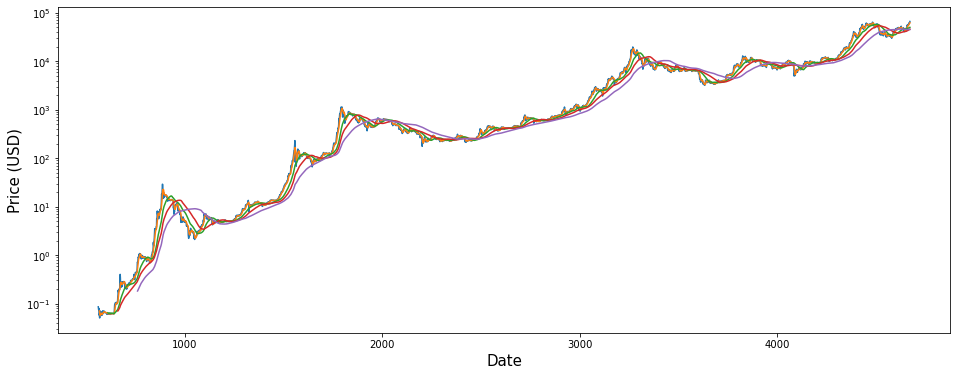

In [38]:
# Visualize the whole dataset:
price_usd = df['BTC / USD Denominated Closing Price']
dma_7 = price_usd.rolling(window=7).mean()
dma_50 = price_usd.rolling(window=50).mean()
dma_100 = price_usd.rolling(window=100).mean()
dma_200 = price_usd.rolling(window=200).mean()


plt.figure(figsize = (16,6))
price_usd.plot(label='PriceUSD')
dma_7.plot(label='7 DMA')
dma_50.plot(label='50 DMA')
dma_100.plot(label='100 DMA')
dma_200.plot(label='200 DMA')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.yscale('log')

plt.show()

### Train Set Vs. SVR(RBF):
Plotting the training data we can see the model struggles to create a multidimensional plane that can separate prices that are orders of magnitude higher than the historical average. 

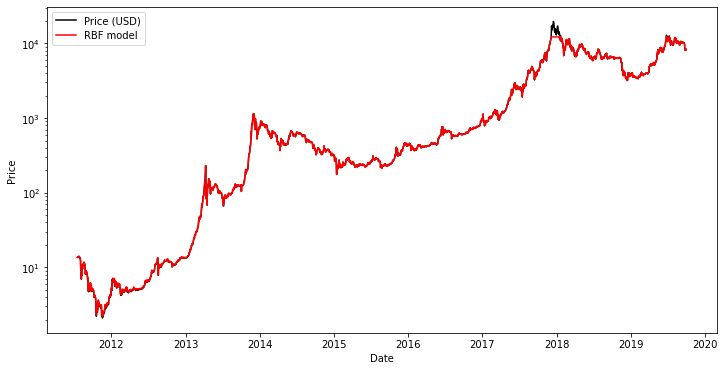

In [39]:
plt.figure(figsize = (12,6))
plt.plot(X_train.index, y_train, color= 'black', label= 'Price (USD)')
plt.plot(X_train.index, svr_rbf.predict(X_train), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.yscale('log')
plt.show()

### Test Set Vs. SVR(RBF):
Plotting the test data we see is veru difficult for the model to not overfit. 

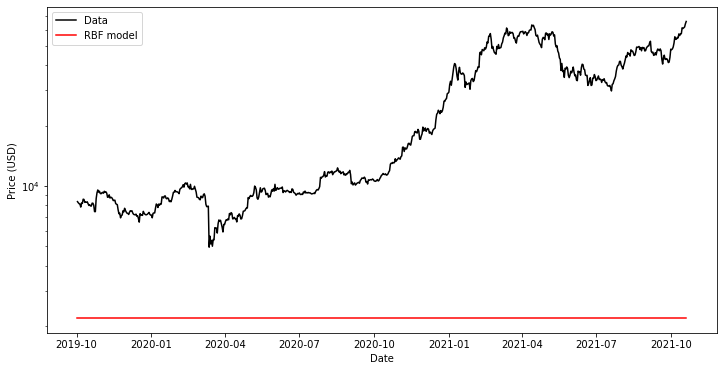

In [40]:
plt.figure(figsize = (12,6))
plt.plot(X_test.index, y_test, color= 'black', label= 'Data')
plt.plot(X_test.index, svr_rbf.predict(X_test), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.yscale('log')
plt.show()

# SVR with standardized data:

## Transforming, Splitting, and Fitting:

In [41]:
# Using predefined function to split and scale at the same time:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scaling_splitting_df(
                                    preprocessing(df, 'Time'), 1, 0.2, StandardScaler())

# Fitting the model:
svr_rbf = SVR(kernel= 'rbf', C= 1, gamma= 0.001)
svr_rbf.fit(X_train_scaled, y_train_scaled)

SVR(C=1, gamma=0.001)

## Data Visualization:

### Transformed Price:
Lets plot the original price transformed vs the transformation oof the train/test sets independently

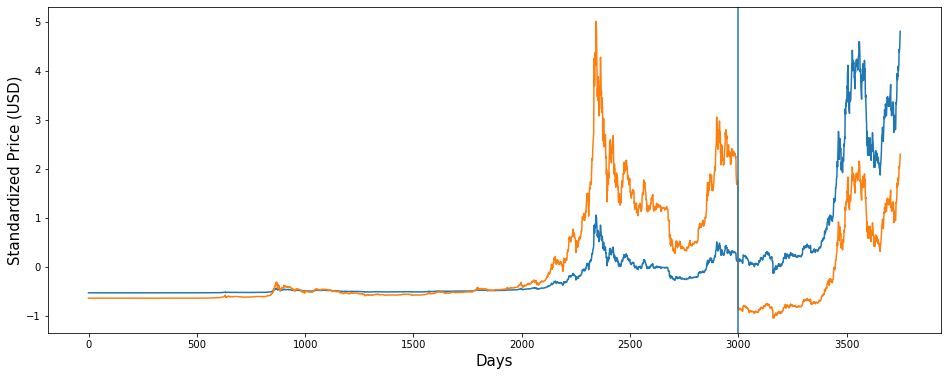

In [42]:
# Scaling the whole series Vs. Scaling Train and Test independently
tot_series_scaled = StandardScaler().fit_transform(preprocessing(df, 'Time'))[:,1]
split_scaled_joined = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
plt.figure(figsize = (16,6))
plt.plot(tot_series_scaled)
plt.plot(split_scaled_joined)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Standardized Price (USD)',fontsize=15)
plt.axvline(x = int(tot_series_scaled.shape[0] * (1 - 0.2)))
# plt.yscale('log')

plt.show()

### Train Set Vs. SVR(RBF):
Plotting the training data we can see the model does a much better job when scaling.  

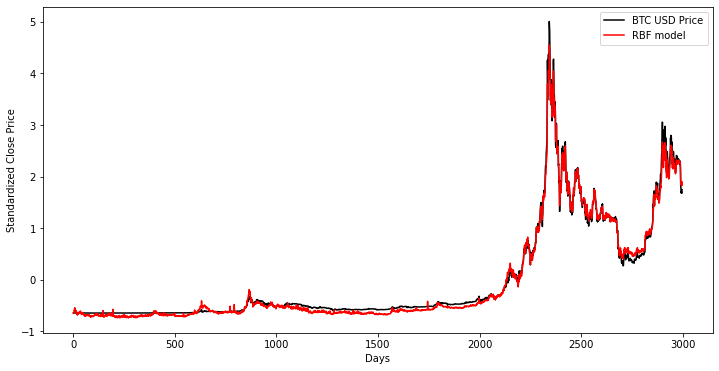

In [43]:
plt.figure(figsize = (12,6))
plt.plot(y_train_scaled, color= 'black', label= 'BTC USD Price')
plt.plot(svr_rbf.predict(X_train_scaled), color= 'red', label= 'RBF model') 
plt.xlabel('Days')
plt.ylabel('Standardized Close Price')
plt.legend()
# plt.yscale('log')
plt.show()

### Test Set Vs. SVR(RBF):
The test seat also prerforms much better

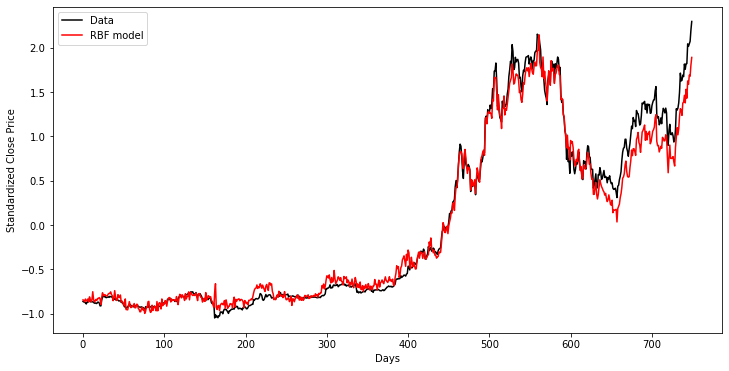

In [44]:
plt.figure(figsize = (12,6))
plt.plot(y_test_scaled, color= 'black', label= 'Data')
plt.plot(svr_rbf.predict(X_test_scaled), color= 'red', label= 'RBF model') 
plt.xlabel('Days')
plt.ylabel('Standardized Close Price')
plt.legend()
# plt.yscale('log')
plt.show()

# SVR with normalized data:

## Transforming, Splitting, and Fitting:

In [45]:
# Using predefined function to split and scale at the same time:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scaling_splitting_df(
                                    preprocessing(df, 'Time'), 1, 0.2, MinMaxScaler(feature_range = (0, 1)))

# Fitting the model:
svr_rbf = SVR(kernel= 'rbf', C= 1, gamma= 0.01)
svr_rbf.fit(X_train_scaled, y_train_scaled)

SVR(C=1, gamma=0.01)

## Data Visualization:

### Transformed Price:
Lets plot the original price transformed vs the transformation oof the train/test sets independently

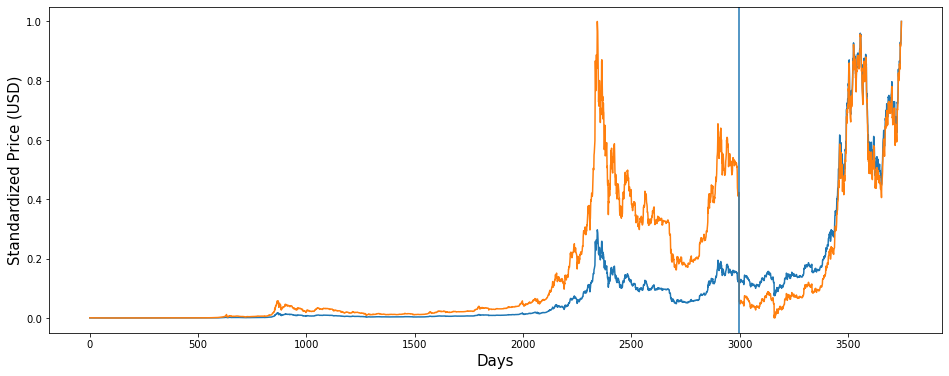

In [46]:
# Scaling the whole series Vs. Scaling Train and Test independently
tot_series_scaled = MinMaxScaler(feature_range = (0, 1)).fit_transform(preprocessing(df, 'Time'))[:,1]
split_scaled_joined = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
plt.figure(figsize = (16,6))
plt.plot(tot_series_scaled, label= 'Whole Series')
plt.plot(split_scaled_joined, label= 'Train/Test Independently')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Standardized Price (USD)',fontsize=15)
plt.axvline(x = int(tot_series_scaled.shape[0] * (1 - 0.2)))
# plt.yscale('log')

plt.show()

### Train Set Vs. SVR(RBF):
Plotting the training data we can see the model does a much better job when scaling.  

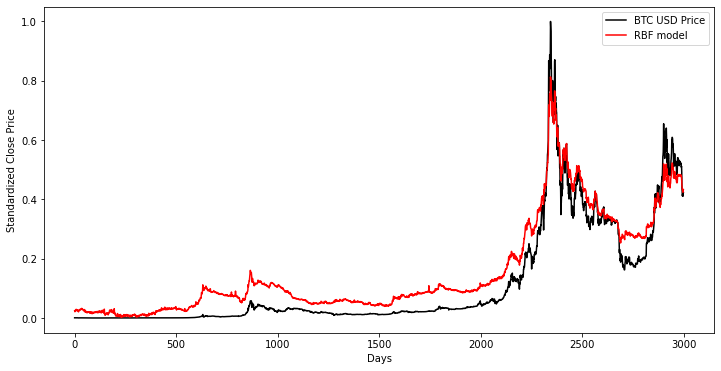

In [47]:
plt.figure(figsize = (12,6))
plt.plot(y_train_scaled, color= 'black', label= 'BTC USD Price')
plt.plot(svr_rbf.predict(X_train_scaled), color= 'red', label= 'RBF model') 
plt.xlabel('Days')
plt.ylabel('Standardized Close Price')
plt.legend()
# plt.yscale('log')
plt.show()

### Test Set Vs. SVR(RBF):
The test seat also prerforms much better

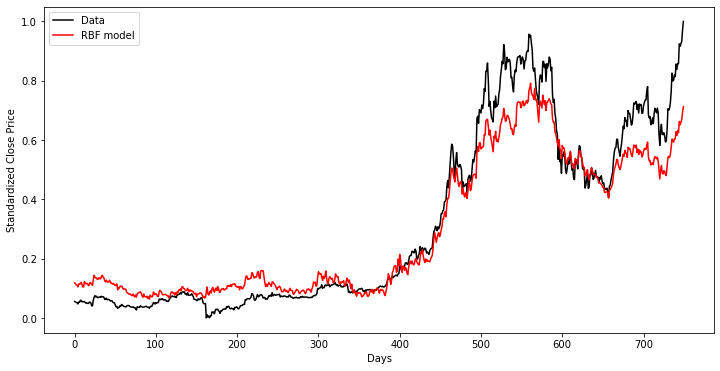

In [48]:
plt.figure(figsize = (12,6))
plt.plot(y_test_scaled, color= 'black', label= 'Data')
plt.plot(svr_rbf.predict(X_test_scaled), color= 'red', label= 'RBF model') 
plt.xlabel('Days')
plt.ylabel('Standardized Close Price')
plt.legend()
# plt.yscale('log')
plt.show()

# LSTM model:
LSTM models use update gates and forget gates to randomly remember and forget pieces of historical information to inform their prediction.

## Data Preparation:
First we scale and split the data in training and testing sets:

In [149]:
# First we perform the train test split and apply the scaling we want:
train_scaled, test_scaled = scaling_splitting_df(preprocessing(df, 'Time'),
    y_column_num=1, test_percent=0.2, scaler=MinMaxScaler(feature_range = (0, 1)), pickle_scalers=True, x_y_split=False)


### Function for grouping observations in windows:
We create a function that takes the scaled data and compounds it in windows. Before this, each datapoint is a point in time (minute, hour, day, week, depending on the resolution we are using). But now, each datapoint is going to represent a window of the previous x observations in the moment t, X being the size of the window, or how much we want the model to consider to remmeber on the short term.

In [140]:
# Prepare the training data
def dataset_in_windows(dataset, window_size):
    '''Returns 3D-arrays with dimesions mXnXj. Where:
    - m = total columns - window size
    - n = window size
    - j = features
    
    Parameters:
    - dataset: array of the dataset (both X and y)
    - window_size: how many observations back to include in the window'''

    X = []
    Y = []

    for i in range(window_size, dataset.shape[0]-window_size):
        X.append(dataset[i-window_size:i, :])
        Y.append(dataset[i, :])

    X, Y = np.array(X), np.array(Y)

    return X, Y

### Creating the windows:
Now we create the windows the RNN will use as the input:

In [150]:
# Define the window size:
window = 50

In [151]:
# for the training set
X_train, Y_train = dataset_in_windows(dataset=train_scaled, window_size=window)
print('Dimensions of X_train: ', X_train.shape)
print('Dimensions of Y_train: ', Y_train.shape)

# for the testing set:
X_test, Y_test = dataset_in_windows(dataset=test_scaled, window_size=window)
print('Dimensions of X_test: ', X_test.shape)
print('Dimensions of Y_test: ', Y_test.shape)

Dimensions of X_train:  (2898, 50, 25)
Dimensions of Y_train:  (2898, 25)
Dimensions of X_test:  (650, 50, 25)
Dimensions of Y_test:  (650, 25)


## Modeling:
Now we define what the architecture of the neural network is going to be.

In [152]:
# This model will go from layer to layer in sequence:
model = Sequential()

# Number of epochs:
epochs = 10

# And this are the layers:
model.add(LSTM(units=window, return_sequences=True, input_shape=(window, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=window, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=window, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=window))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))
model.compile(loss="mse", optimizer="adam")

# Now we fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=epochs)
# model.summary

# And we save it for future use:
model.save('data/LSTM_BTC_'+str(window)+'_windowsize_'+str(epochs)+'_epochs.h5')
print('Model Saved as'+'LSTM_BTC_'+str(window)+'_windowsize_'+str(epochs)+'_epochs.h5')

Epoch 1/10
91/91 [==============================] - 14s 149ms/step - loss: 0.0314
Epoch 2/10
91/91 [==============================] - 13s 142ms/step - loss: 0.0127
Epoch 3/10
91/91 [==============================] - 13s 145ms/step - loss: 0.0096
Epoch 4/10
91/91 [==============================] - 13s 145ms/step - loss: 0.0084
Epoch 5/10
91/91 [==============================] - 13s 143ms/step - loss: 0.0073
Epoch 6/10
91/91 [==============================] - 13s 144ms/step - loss: 0.0066
Epoch 7/10
91/91 [==============================] - 13s 140ms/step - loss: 0.0062
Epoch 8/10
91/91 [==============================] - 13s 148ms/step - loss: 0.0059
Epoch 9/10
91/91 [==============================] - 13s 145ms/step - loss: 0.0055
Epoch 10/10
91/91 [==============================] - 14s 151ms/step - loss: 0.0052
Model Saved asLSTM_BTC_50_windowsize_10_epochs.h5


## Evaluation:
Let's proceed to see how the model performed agains training and testing data:

In [129]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on training data')
results = model.evaluate(X_train, Y_train, batch_size=32, return_dict=True)
print('Train Evaluation Result:', results)
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test, batch_size=32, return_dict=True)
print('Test Evaluation Result:', results)


# Evaluate on training data
91/91 [==============================] - 7s 74ms/step - loss: 0.0024
Train Evaluation Result: {'loss': 0.002411013236269355}

# Evaluate on test data
21/21 [==============================] - 2s 79ms/step - loss: 0.0662
Test Evaluation Result: {'loss': 0.06617898494005203}


## Predictions:

In [162]:
# Predict values with the testing data:
Y_pred = model.predict(X_test)

# Inverse transforming predictions:
unpkl_testing_scaler = pickle.load(open('data/testing_scaler.pkl','rb'))
Y_pred_inv_tr = unpkl_testing_scaler.inverse_transform(Y_pred)

# Inverse transforming Y_test:
Y_test_inv_tr = unpkl_testing_scaler.inverse_transform(Y_test)


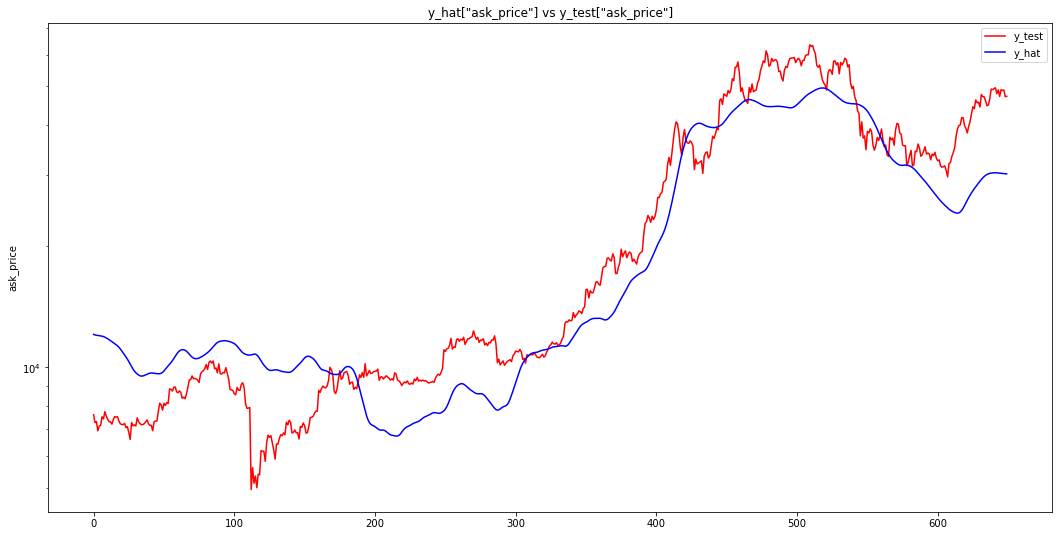

In [169]:
# Visualise the ask_price predictions
plt.figure(figsize = (18,9))
plt.plot(Y_test_inv_tr[:,1], color = 'red', label = 'y_test')
plt.plot(Y_pred_inv_tr[:,1], color = 'blue', label = 'y_hat')
plt.title('y_hat["ask_price"] vs y_test["ask_price"]')
plt.ylabel('ask_price')
plt.legend()
plt.yscale('log')
plt.show()

In [171]:
df.tail()

,Time,BTC / USD Denominated Closing Price,BTC / Free Float Market Cap (USD),BTC / Realized Market Cap (USD),BTC / Active Market Cap (1yr) (USD),BTC / 30 Day Volatility,BTC / 180 Day Volatility,"BTC / ROI, 1 Year","BTC / ROI, 30 Days",BTC / Annual Inflation Rate,...,BTC / Value in Top 10% of Addrs (native units),BTC / Value in Top 1% of Addrs (native units),BTC / Total Fees (native units),BTC / Miner Revenue (native units),BTC / NVT,BTC / Mean Hash Rate,BTC / Difficulty,BTC / Exchange Deposits (native units),BTC / Exchange Withdrawals (native units),BTC / Miner Supply (native units)
4669,2021-10-16,60932.063212,8.850671e+11,4.167951e+11,5.282887e+11,0.041404,0.042173,437.367776,27.480061,1.609965,...,1.866171e+07,1.725065e+07,15.434662,846.684662,84.956180,1.315222e+08,1.989305e+13,19749.903680,11579.048564,1.798318e+06
4670,2021-10-17,61462.222372,8.928154e+11,4.174171e+11,5.327219e+11,0.041225,0.042169,440.907262,30.178528,1.936697,...,1.866253e+07,1.725102e+07,11.310294,1011.310294,117.153052,1.582222e+08,1.989305e+13,9566.307540,11389.491044,1.798489e+06
4671,2021-10-18,61977.057551,9.003317e+11,4.204438e+11,5.393226e+11,0.041163,0.042039,439.417698,28.572401,1.791357,...,1.866385e+07,1.725614e+07,15.971247,940.971247,57.017267,1.465815e+08,2.008246e+13,23466.427777,26568.856321,1.798324e+06
4672,2021-10-19,64290.897757,9.340006e+11,4.224533e+11,5.598689e+11,0.041098,0.042009,447.351668,36.156238,1.875987,...,1.866471e+07,1.725672e+07,14.856384,983.606384,57.787489,1.547372e+08,2.008246e+13,33603.268908,39997.994668,1.798231e+06
4673,2021-10-20,66061.796564,9.597424e+11,4.252345e+11,5.753737e+11,0.035842,0.042028,453.770345,54.150064,1.803279,...,1.866583e+07,1.725854e+07,19.073957,950.323957,59.396011,1.487474e+08,2.008246e+13,22460.813615,23550.792549,1.798003e+06
